## Regression Model

We can technically stop at our classification task, as our imaginary client might be satisfied in knowing whether their campaign will be successful or not given the required inputs. However, what can we do more? Perhaps, we can help them to estimate how much are they likely to raise with the given variables. We can attempt to predict the probability of whether they are likely to success and use this as an input to finally output how much are they likely to raise as a result. To do this, first, we need to find the right model to predict the probability. Next, we will need to find out whether there is a correlation between this probability and how much they are likely to raise.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
print("done")

done


In [2]:
# Data Processing
df = pd.read_csv("variables.csv")
df = df.drop(['Unnamed: 0'],axis=1)
df_x = df[['Total_Days','currency','category','month_launch']]
df_y = df[['amount_raised_usd_boxcox','state']]
df_x_onehot = df_x.copy()

for c in df_x_onehot.columns:
    df_x_onehot[c] = df_x_onehot[c].astype('object') # changing to object type for onehot processsing
    
df_x_onehot = pd.get_dummies(df_x_onehot)
df_x_noText = df_x_onehot.copy()
df_x_Text = df_x_onehot.copy()
text_df = pd.read_csv("text_results_cleaned.csv")
df_x_Text['compound_tag_vader'] = text_df['compound_tag_vader']
df_x_Text['pos_tag_disBert'] = text_df['pos_tag_disBert']
df_x_Text['compound_ti_vader'] = text_df['compound_ti_vader']
df_x_Text['pos_ti_disBert'] = text_df['pos_ti_disBert']

In [3]:
# splitting data
x_train_noText, x_test_noText, y_train_noText, y_test_noText = train_test_split(df_x_noText, df_y,
                                                                             test_size=0.2, stratify=df_y['state'],
                                                                             random_state=42)
x_train_Text, x_test_Text, y_train_Text, y_test_Text = train_test_split(df_x_Text, df_y,
                                                                             test_size=0.2, stratify=df_y['state'],
                                                                             random_state=42)

In [4]:
# fitting into logistic regression model (no Text)
from sklearn.linear_model import LogisticRegression

log_clf_noText = LogisticRegression()
log_clf_noText.fit(x_train_noText, y_train_noText['state'])

LogisticRegression()

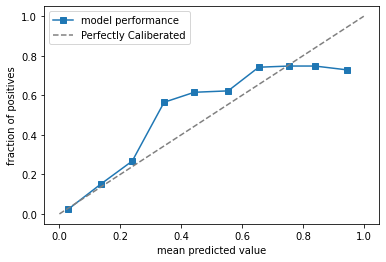

In [5]:
# compare to calibration curve
from sklearn.calibration import calibration_curve
y_train_predict_proba_logNoText = log_clf_noText.predict_proba(x_train_noText)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_train_noText['state'], y_train_predict_proba_logNoText, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-',label='model performance')
plt.plot([0, 1], [0, 1], '--', color='gray',label='Perfectly Caliberated')
plt.xlabel("mean predicted value")
plt.ylabel("fraction of positives")
plt.legend()
plt.show()

In [6]:
# appending results into new dataFrame
df_prob = pd.DataFrame()
df_prob['log_prob_noText'] = y_train_predict_proba_logNoText

In [7]:
# fitting into logistic regression model (Text)
log_clf_Text = LogisticRegression()
log_clf_Text.fit(x_train_Text,y_train_Text['state'])

LogisticRegression()

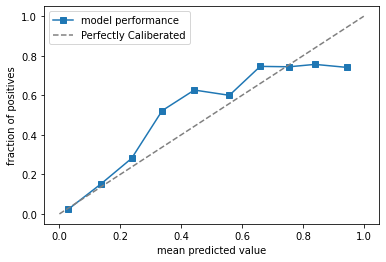

In [8]:
# compare to calibration curve
y_train_predict_proba_logText = log_clf_Text.predict_proba(x_train_Text)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_train_Text['state'], y_train_predict_proba_logText, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-',label='model performance')
plt.plot([0, 1], [0, 1], '--', color='gray',label='Perfectly Caliberated')
plt.xlabel("mean predicted value")
plt.ylabel("fraction of positives")
plt.legend()
plt.show()

In [9]:
# appending results into new dataFrame
df_prob['log_prob_Text'] = y_train_predict_proba_logText

In [10]:
# fitting into Tuned SVC (Text)
from sklearn.svm import SVC
support_clf = SVC(C= 0.1, gamma= 1, kernel= 'rbf',probability=True)
support_clf.fit(x_train_Text,y_train_Text['state'])

SVC(C=0.1, gamma=1, probability=True)

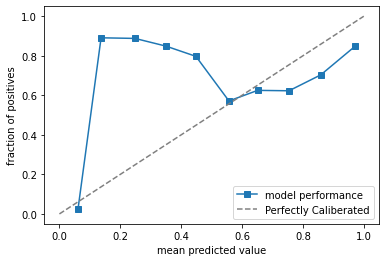

In [11]:
# compare to calibration curve
y_train_predict_proba_SVC = support_clf.predict_proba(x_train_Text)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_train_Text['state'], y_train_predict_proba_SVC, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-',label='model performance')
plt.plot([0, 1], [0, 1], '--', color='gray',label='Perfectly Caliberated')
plt.xlabel("mean predicted value")
plt.ylabel("fraction of positives")
plt.legend()
plt.show()

In [12]:
# appending results into new dataFrame
df_prob['SVC_Tuned_prob'] = y_train_predict_proba_SVC

In [13]:
# fitting into Tuned XGB Classifier (No Text)
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(seed=0,
                       colsample_bytree= 0.5,
                       gamma= 0.1, 
                       learning_rate= 0.0001,
                       max_depth= 12,
                       reg_alpha= 1e-05, 
                       reg_lambda= 1e-05)

xgb_clf.fit(x_train_noText,y_train_noText['state'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

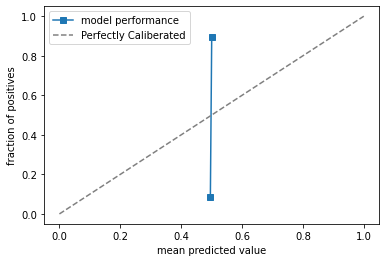

In [14]:
# compare to calibration curve
y_train_predict_proba_XGB_Tuned = xgb_clf.predict_proba(x_train_noText)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_train_noText['state'], y_train_predict_proba_XGB_Tuned, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-',label='model performance')
plt.plot([0, 1], [0, 1], '--', color='gray',label='Perfectly Caliberated')
plt.xlabel("mean predicted value")
plt.ylabel("fraction of positives")
plt.legend()
plt.show()

In [15]:
# appending results into new dataFrame
df_prob['xgboost_Tuned_prob'] = y_train_predict_proba_XGB_Tuned


In [16]:
# fitting into default XGB Classifier (No Text)
xgb_clf = XGBClassifier(seed=0)
xgb_clf.fit(x_train_noText,y_train_noText['state'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

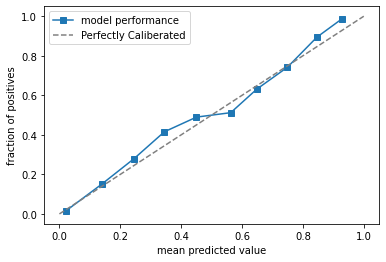

In [17]:
# compare to calibration curve
y_train_predict_proba_XGB_default = xgb_clf.predict_proba(x_train_noText)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_train_noText['state'], y_train_predict_proba_XGB_default, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-',label='model performance')
plt.plot([0, 1], [0, 1], '--', color='gray',label='Perfectly Caliberated')
plt.xlabel("mean predicted value")
plt.ylabel("fraction of positives")
plt.legend()
plt.show()

In [18]:
# appending results into new dataFrame
df_prob['xgboost_default_prob_noText'] = y_train_predict_proba_XGB_default

In [19]:
df_test_prob = pd.DataFrame()
df_test_prob['xgboost_default_prob_noText'] = xgb_clf.predict_proba(x_test_noText)[:, 1]

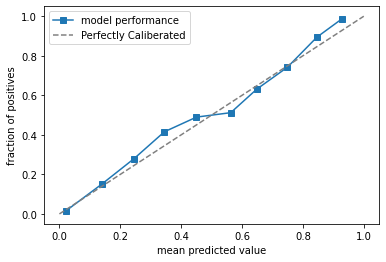

In [20]:
# fitting into default XGB Classifier (Text)
xgb_clf = XGBClassifier(seed=0)
xgb_clf.fit(x_train_Text,y_train_Text['state'])
y_train_predict_proba_XGB_default_Text = xgb_clf.predict_proba(x_train_Text)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_train_noText['state'], y_train_predict_proba_XGB_default, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, 's-',label='model performance')
plt.plot([0, 1], [0, 1], '--', color='gray',label='Perfectly Caliberated')
plt.xlabel("mean predicted value")
plt.ylabel("fraction of positives")
plt.legend()
plt.show()

In [21]:
df_prob['xgboost_default_prob_Text'] = y_train_predict_proba_XGB_default_Text
df_test_prob['xgboost_default_prob_Text'] = xgb_clf.predict_proba(x_test_Text)[:, 1]

We see that out of all the models, the default xgboost classifier has the smallest deviation with a perfectly caliberated model. We will use the results as our predictor.

#### Viewing statistical relationship when just considering probability as a variable

In [24]:
df_prob['amount_raised_usd_boxcox'] = y_train_noText['amount_raised_usd_boxcox']

In [25]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr
def pearson_corr(x,y,data):
    corr = data.corr()[y][x]
    print('Pearson correlation: %.5f' % corr)
    
def kendall_rank_corr(x,y,data):
    corr, _ = kendalltau(data[x], data[y])
    print('Kendall Rank correlation: %.5f' % corr)
def spearman_corr(x,y,data):
    rho, _ = spearmanr(data[x], data[y])
    print('Spearman\'s Correlation: %.5f' % rho)

In [26]:
pearson_corr('xgboost_default_prob_noText','amount_raised_usd_boxcox',df_prob)
kendall_rank_corr('xgboost_default_prob_noText','amount_raised_usd_boxcox',df_prob)
spearman_corr('xgboost_default_prob_noText','amount_raised_usd_boxcox',df_prob)

Pearson correlation: -0.00866
Kendall Rank correlation: nan
Spearman's Correlation: nan


From the look at it, it seems that there is almost no statistical relationship between predicted probability of success state and the amount of funds raised from it. Well, this is to be expected, as for example I say that your project will have a certain chances to succeed, without any referrence, will you know how much you are likely to raise? Perhaps, we will need to provide an anchor, which is the goal_usd in this case for it to be consider a meaningful variable. But first thing first, we will need to find out how model perform with base case predictors. We will use <b>XGB regressor</b> in doing this task.

In [40]:
# base performance of regressor

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

xgb_reg = XGBRegressor(seed=0)
xgb_reg.fit(x_train_Text,y_train_Text)
pred = xgb_reg.predict(x_test_Text)
MSE = mean_squared_error(y_test_Text,pred)
MAE = mean_absolute_error(y_test_Text,pred)
r2 = r2_score(y_test_Text,pred)

In [41]:
print("MSE =", MSE)
print("MAE =",MAE)
print("Explained Variance =",r2)

MSE = 0.7787636061551344
MAE = 0.5205340166444112
Explained Variance = 0.36611807023362064


In [42]:
xgb_reg = XGBRegressor(seed=0)
xgb_reg.fit(x_train_noText,y_train_noText)
pred = xgb_reg.predict(x_test_noText)
MSE = mean_squared_error(y_test_noText,pred)
MAE = mean_absolute_error(y_test_noText,pred)
r2 = r2_score(y_test_noText,pred)

In [43]:
print("MSE =", MSE)
print("MAE =",MAE)
print("Explained Variance =",r2)

MSE = 0.7757057279567374
MAE = 0.517750151596635
Explained Variance = 0.3703936153753848


We see that an explained variance of about 0.365 to 0.37, with MSE of 0.77, MAE of 0.52. Does not seem to be a very good score in prediction. Let's see if we can do better with additional predictor of probability.

### Probabilities predicted and goal_usd as additional predictor.

In [59]:
# Data Processing
from scipy.stats import boxcox
data = pd.read_csv("data.csv")
data_goal = pd.DataFrame(data['goal_usd'])
transformed_data, best_lambda = boxcox(data_goal['goal_usd'])
data_goal['goal_usd_boxcox'] = transformed_data
data_goal.head()

,goal_usd,goal_usd_boxcox
0,5000.0,8.767282
1,1200.0,7.262817
2,1200.0,7.262817
3,2000.0,7.799661
4,55000.0,11.328069


In [60]:
# adding goal_usd_boxcox to training data
df_x_noText['goal_usd_boxcox'] = data_goal['goal_usd_boxcox']
df_x_Text['goal_usd_boxcox'] = data_goal['goal_usd_boxcox']

In [61]:
x_train_noText, x_test_noText, y_train_noText, y_test_noText = train_test_split(df_x_noText, df_y,
                                                                             test_size=0.2, stratify=df_y['state'],
                                                                             random_state=42)
x_train_Text, x_test_Text, y_train_Text, y_test_Text = train_test_split(df_x_Text, df_y,
                                                                             test_size=0.2, stratify=df_y['state'],
                                                                             random_state=42)

In [62]:
# adding the probabilities
x_train_noText_reg = x_train_noText.reset_index()
x_train_noText_reg = x_train_noText_reg.join(df_prob['xgboost_default_prob_noText'])
x_train_noText_reg.tail()

,index,Total_Days_0,Total_Days_1,Total_Days_2,Total_Days_3,Total_Days_4,Total_Days_5,Total_Days_6,Total_Days_7,Total_Days_8,...,month_launch_5,month_launch_6,month_launch_7,month_launch_8,month_launch_9,month_launch_10,month_launch_11,month_launch_12,goal_usd_boxcox,xgboost_default_prob_noText
16489,2800,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9.503253,0.084106
16490,12121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,7.122790,0.005086
16491,9771,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,9.503253,0.200987
16492,5673,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,11.973012,0.097299
16493,16300,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,8.655714,0.015395


In [63]:
x_train_noText_reg = x_train_noText_reg.drop(['index'],axis=1)

In [65]:
y_train_noText_reg = y_train_noText.reset_index()
y_train_noText_reg = y_train_noText_reg.drop(['index','state'],axis=1)

In [67]:
xgb_reg = XGBRegressor(seed=0)
xgb_reg.fit(x_train_noText_reg,y_train_noText_reg)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [68]:
x_test_noText_reg = x_test_noText.reset_index()
x_test_noText_reg = x_test_noText_reg.join(df_test_prob['xgboost_default_prob_noText'])
y_test_noText_reg = y_test_noText.reset_index()
y_test_noText_reg = y_test_noText_reg.drop(['index','state'],axis=1)

In [72]:
x_test_noText_reg = x_test_noText_reg.drop(['index'],axis=1)

In [74]:
pred = xgb_reg.predict(x_test_noText_reg)
MSE = mean_squared_error(y_test_noText_reg,pred)
MAE = mean_absolute_error(y_test_noText_reg,pred)
r2 = r2_score(y_test_Text_reg,pred)

print("MSE =", MSE)
print("MAE =",MAE)
print("Explained Variance =",r2)

MSE = 1.525312451671979
MAE = 0.9356327722603994
Explained Variance = 0.3287994348434883


In [75]:
# adding the probabilities
x_train_Text_reg = x_train_Text.reset_index()
x_train_Text_reg = x_train_Text_reg.join(df_prob['xgboost_default_prob_Text'])
x_train_Text_reg.tail()
x_train_Text_reg = x_train_Text_reg.drop(['index'],axis=1)
y_train_Text_reg = y_train_Text.reset_index()
y_train_Text_reg = y_train_Text_reg.drop(['index','state'],axis=1)
xgb_reg = XGBRegressor(seed=0)
xgb_reg.fit(x_train_Text_reg,y_train_Text_reg)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [76]:
x_test_Text_reg = x_test_Text.reset_index()
x_test_Text_reg = x_test_Text_reg.join(df_test_prob['xgboost_default_prob_Text'])
y_test_Text_reg = y_test_Text.reset_index()
y_test_Text_reg = y_test_Text_reg.drop(['index','state'],axis=1)
x_test_Text_reg = x_test_Text_reg.drop(['index'],axis=1)

pred = xgb_reg.predict(x_test_Text_reg)
MSE = mean_squared_error(y_test_Text_reg,pred)
MAE = mean_absolute_error(y_test_Text_reg,pred)
r2 = r2_score(y_test_Text_reg,pred)

print("MSE =", MSE)
print("MAE =",MAE)
print("Explained Variance =",r2)

MSE = 1.57273455418588
MAE = 0.9516479085922857
Explained Variance = 0.30793174837482407


It seems that we actually performed worst with the probabilities and the goal_usd_boxcox known. Perhaps, they are not good predictors as seen from the correlation statistics before. We will thus stick with the default predictor since they yield better results. This thus suggest that perhaps on indiegogo platform in fund raising, having an anchor point (goal of how much to raise), does not actually increase the amount of funds you raise. 

Also, there is rather weak explained variance for how much we are likely to raise, but a high precision for our classification model done previously. One reason for this is that our model for our classification mostly predict inputs that it is not sure with certainty as false, as it suit the needs of an imaginary client better. 

Another may be that the predictors we used may not be sufficient in predicting the use case. Perhaps, more factors will be needed to for better predictions. For instance, our text data only uses sentiment scores as predictors, perhaps there are more unknown information that we can possibly extract from the text other than sentiment score, that may be a better predictor. 

Also, there may be external factors that we did not incorporate into such as trends, interest rates etc, that could possibly probe up the score for our prediction. Nonetheless, the project so far is derived from the known variables given and some sort of feature engineering that our team could come up with. We are rather satisfied with the results that it could classify the business cases with high precision.

Thanks for reading our project:)